# Import Functions

In [1]:
import pencilbox as pb
import pandas as pd
import numpy as np
import time
import os
from datetime import date, datetime, timedelta
import json
import shutil 
!pip install pymysql
import pymysql

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
#from pyemma import msm
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

import boto3
import io

!pip install matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.ensemble import IsolationForest


import requests
from requests.exceptions import HTTPError

!pip install pandasql
import pandasql as ps

from tqdm.notebook import tqdm
CON_REDSHIFT = pb.get_connection("[Warehouse] Redshift")
CON_TRINO = pb.get_connection("[Warehouse] Trino")

In [2]:
def read_sql_query(sql, con):
    max_tries = 3
    for attempt in range(max_tries):
        print(f"Read attempt: {attempt}...")
        try:
            start = time.time()
            df = pd.read_sql_query(sql, con)
            end = time.time()
            if (end - start) > 60:
                print("Time: ", (end - start) / 60, "min")
            else:
                print("Time: ", end - start, "s")
            return df
            break
        except BaseException as e:
            print(e)
            time.sleep(5)

In [3]:
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 300)
import warnings
warnings.filterwarnings('ignore')

In [4]:
outliers_fraction = 0.01
final_df = pd.DataFrame()

# Fetch Sales

In [5]:
order_query = f"""
with
item_details as
    (select item_id, 
        (id.name || ' ' || id.variant_description) as item_name
            from lake_rpc.item_details id
    ),

item_mapping as
    (select distinct ipr.product_id,
        case when ipr.item_id is null then ipom_0.item_id else ipr.item_id end as item_id,
        case when ipr.item_id is not null then COALESCE(ipom.multiplier,1) else COALESCE(ipom_0.multiplier,1) end as multiplier
            
            from lake_rpc.item_product_mapping ipr

                left join
                    dwh.dim_item_product_offer_mapping ipom on ipom.product_id = ipr.product_id
                        and ipr.item_id = ipom.item_id
                left join
                    dwh.dim_item_product_offer_mapping ipom_0 on ipom_0.product_id = ipr.product_id
    ),

sales as
    (select 
        (oid.cart_checkout_ts_ist) as order_date,
        cl.name as city_name,
        rco.facility_id,
        pt.name as p_type,
        oid.product_id,
        im.item_id,
        oid.cart_id,
        oid.dim_customer_key,
        ((unit_selling_price * 1.00)/im.multiplier) as item_selling_price,
        ((unit_mrp * 1.00)/im.multiplier) as item_selling_mrp,
        im.multiplier,
        oid.total_doorstep_return_quantity,
        ((oid.procured_quantity - oid.total_doorstep_return_quantity) * im.multiplier) as sales_quantity,
        (sales_quantity * item_selling_price) as sales_value,
        (sales_quantity * item_selling_mrp) as sales_value_mrp
        
            from dwh.fact_sales_order_item_details oid
            
                join item_mapping im on im.product_id = oid.product_id
                
                join lake_retail.console_outlet rco on rco.id = oid.outlet_id and business_type_id in (7)
                join lake_retail.console_location cl on cl.id = rco.tax_location_id
                left join 
        (select item_id, product_id from lake_rpc.item_product_mapping) ipm on ipm.product_id = oid.product_id
    left join 
        (select id, type_id from lake_cms.gr_product) gp on gp.id = ipm.product_id
    left join 
        (select id, name from lake_cms.gr_product_type) pt on pt.id = gp.type_id
                
                    where (oid.cart_checkout_ts_ist between (current_date - 90 || ' 00:00:00')::timestamp and (current_date || ' 23:59:59')::timestamp)
                        and oid.is_internal_order = false
                        and (oid.order_type not ilike '%%internal%%' or oid.order_type is null)
                        and oid.procured_quantity > 0
                        and oid.order_current_status = 'DELIVERED'
    ),

cart_data AS
  (
    SELECT 
        DISTINCT cart_id,
        sum(sales_quantity) AS order_quantity
    FROM 
        sales
    GROUP BY 1
),

final_sales as
    (select 
        date(order_date) as date_,
        p_type,
        s.item_id,
        item_name, 
        sum(sales_quantity)::int as sales_quantity,
        sum(sales_value) as sales_value,
        sum(sales_value_mrp) as sales_value_mrp,
        avg(cast(sales_quantity AS float)/cast(order_quantity AS float)) AS ipc
        
            from sales s
            
                join
                    item_details id on id.item_id = s.item_id
                JOIN
        cart_data c ON s.cart_id = c.cart_id
                    
                    where sales_quantity > 0
                    
                        group by 1,2,3,4
    )
    
        SELECT fs.*
        FROM final_sales fs
        WHERE fs.item_id IN (10000953) -- (10000953, 10043867, 10002530, 10000628, 10001013)
            """

order_data = read_sql_query(order_query, CON_REDSHIFT)
order_data['date_'] = pd.to_datetime(order_data['date_'])
order_data.head()

Read attempt: 0...
Time:  1.390855650107066 min


,date_,p_type,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,ipc
0,2023-05-11,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,216,5508.0,5832.0,0.368901
1,2023-05-13,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,210,5355.0,5670.0,0.333919
2,2023-07-08,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,6603,166171.0,178201.0,0.309803
3,2023-04-29,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,994,25225.0,26838.0,0.321981
4,2023-07-21,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,457,11882.0,12339.0,0.314086


In [6]:
#order_df = pd.read_csv('sample-orders-data.csv')
order_df = order_data.copy()
order_df['Sales'] = order_df['sales_quantity']
order_df['Sales'].describe()

# order_df.head(2)

count      91.000000
mean     1743.890110
std      1913.373887
min       112.000000
25%       797.500000
50%      1026.000000
75%      1345.500000
max      7733.000000
Name: Sales, dtype: float64

In [7]:
order_df.head()

,date_,p_type,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,ipc,Sales
0,2023-05-11,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,216,5508.0,5832.0,0.368901,216
1,2023-05-13,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,210,5355.0,5670.0,0.333919,210
2,2023-07-08,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,6603,166171.0,178201.0,0.309803,6603
3,2023-04-29,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,994,25225.0,26838.0,0.321981,994
4,2023-07-21,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,457,11882.0,12339.0,0.314086,457


In [8]:
item_ptype_mapping = order_data[['p_type','item_id','item_name']].drop_duplicates()
item_ptype_mapping.head()

,p_type,item_id,item_name
0,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27


# EDA

In [9]:
order_df.isna().sum()

date_              0
p_type             0
item_id            0
item_name          0
sales_quantity     0
sales_value        0
sales_value_mrp    0
ipc                0
Sales              0
dtype: int64

In [10]:
order_df = order_df.dropna()

In [11]:
order_df['date_'] = pd.to_datetime(order_df['date_'])

In [12]:
order_df['date_'].min()

Timestamp('2023-04-22 00:00:00')

In [13]:
order_df['date_'].max()

Timestamp('2023-07-21 00:00:00')

In [14]:
order_df = order_df.sort_values(by='date_').reset_index(drop = True)

In [15]:
order_df.head()

,date_,p_type,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,ipc,Sales
0,2023-04-22,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1020,26386.0,27540.0,0.245811,1020
1,2023-04-23,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1048,27131.0,28294.0,0.238974,1048
2,2023-04-24,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,846,21932.0,22842.0,0.249967,846
3,2023-04-25,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,832,21530.0,22464.0,0.231127,832
4,2023-04-26,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,927,23978.0,25029.0,0.222459,927


In [16]:
x_train = order_df.copy()

## Visualisation

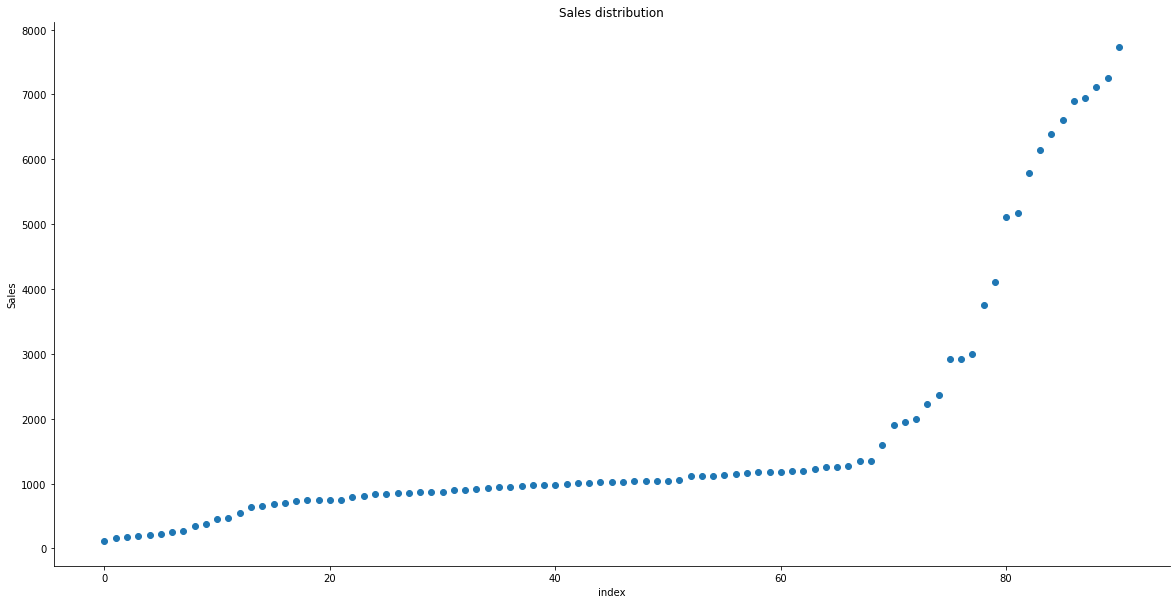

In [17]:
plt.subplots(figsize=(20,10))
plt.scatter(range(x_train.shape[0]), np.sort(x_train['Sales'].values))
plt.xlabel('index')
plt.ylabel('Sales')
plt.title("Sales distribution")
sns.despine()

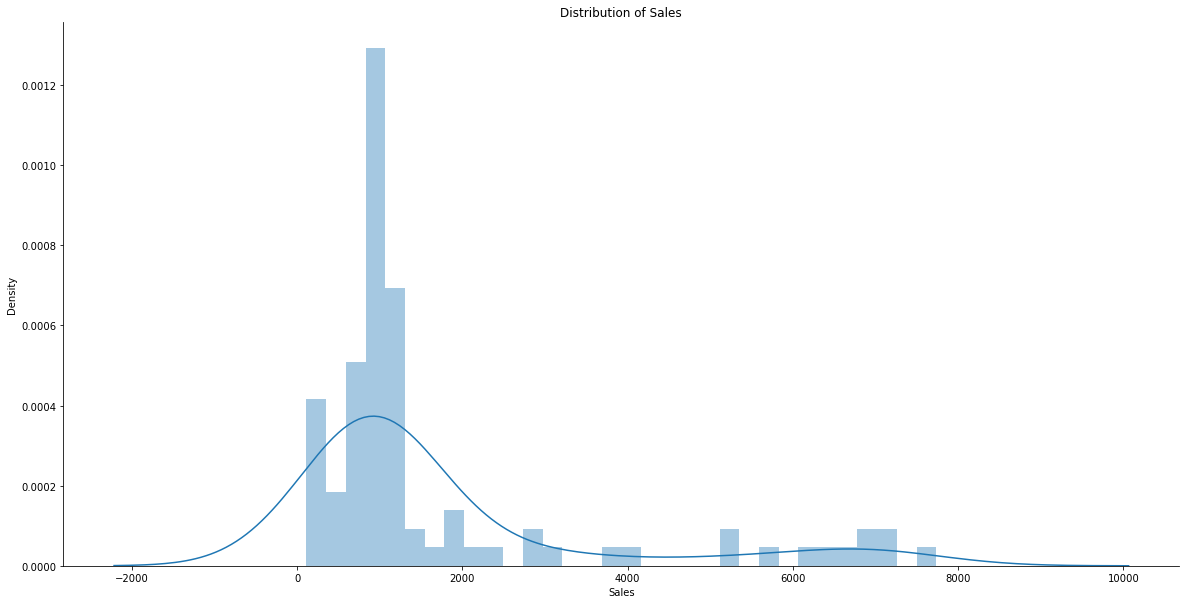

In [18]:
plt.subplots(figsize=(20,10))
sns.distplot(x_train['Sales'])
plt.title("Distribution of Sales")
sns.despine()

In [19]:
x_train['Sales'].skew()

1.974344613684042

# Feature Engineering

In [20]:
x_train = order_df.copy()
#item_id = 10000490
#box_x_train = x_train[x_train['item_id'] == item_id].reset_index().drop(columns = {'index'})
box_x_train = x_train.copy()

In [21]:
# from sklearn.preprocessing import PowerTransformer

# fit = PowerTransformer(
#    method = 'box-cox'
# )

# box_x_train['Sales'] = fit.fit_transform(
#    np.array(box_x_train['sales_quantity']).reshape(-1, 1)
# )

In [22]:
from scipy import stats
box_x_train['Sales'] = stats.boxcox(box_x_train['sales_quantity'])[0]

# plt.subplots(figsize=(20,10))
# plt.scatter(range(box_x_train.shape[0]), np.sort(box_x_train['Sales'].values))
# plt.xlabel('index')
# plt.ylabel('Sales')
# plt.title("Sales distribution")
# sns.despine()

In [23]:
box_x_train.head()

,date_,p_type,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,ipc,Sales
0,2023-04-22,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1020,26386.0,27540.0,0.245811,5.685929
1,2023-04-23,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1048,27131.0,28294.0,0.238974,5.703906
2,2023-04-24,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,846,21932.0,22842.0,0.249967,5.560981
3,2023-04-25,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,832,21530.0,22464.0,0.231127,5.549767
4,2023-04-26,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,927,23978.0,25029.0,0.222459,5.622235


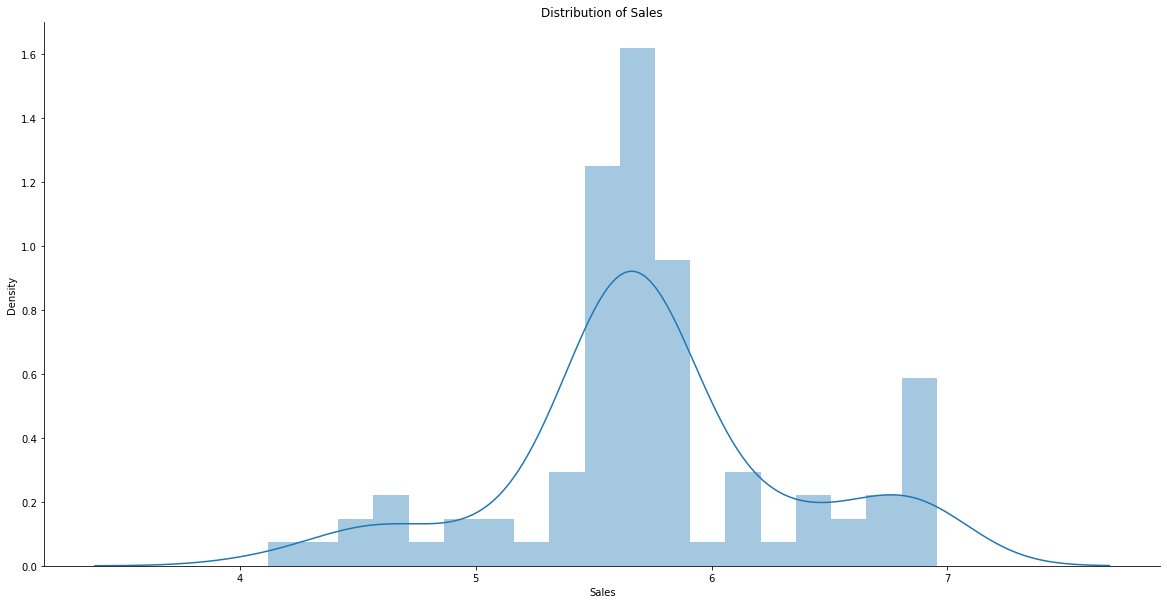

In [24]:
plt.subplots(figsize=(20,10))
sns.distplot(box_x_train['Sales'])
plt.title("Distribution of Sales")
sns.despine()

In [25]:
# plt.subplots(figsize=(20,10))
# sns.distplot(box_x_train['Sales_new'])
# plt.title("Distribution of Sales")
# sns.despine()

In [26]:
box_x_train['Sales'].skew()

-0.007237835805098243

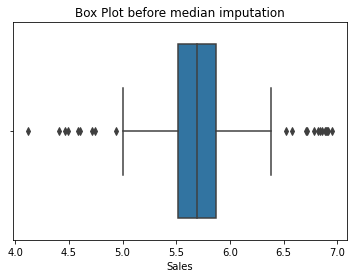

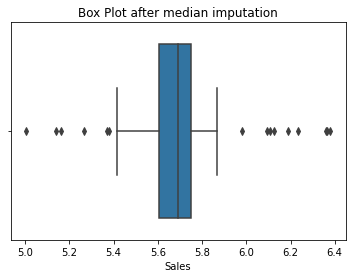

In [27]:
#median imputation

sns.boxplot(box_x_train['Sales'])
plt.title("Box Plot before median imputation")
plt.show()
q1 = box_x_train['Sales'].quantile(0.25)
q3 = box_x_train['Sales'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
med = np.median(box_x_train['Sales'])
for i in box_x_train['Sales']:
    if i > Upper_tail or i < Lower_tail:
            box_x_train['Sales'] = box_x_train['Sales'].replace(i, med)
sns.boxplot(box_x_train['Sales'])
plt.title("Box Plot after median imputation")
plt.show()

# Model

In [28]:
box_x_train['date_'].dt.day

0     22
1     23
2     24
3     25
4     26
      ..
86    17
87    18
88    19
89    20
90    21
Name: date_, Length: 91, dtype: int64

In [29]:
box_x_train['hours'] = box_x_train['date_'].dt.hour
box_x_train['week'] = box_x_train['date_'].dt.week
box_x_train['day'] = box_x_train['date_'].dt.day
box_x_train['month'] = box_x_train['date_'].dt.month
box_x_train['DayOfTheWeek'] = box_x_train['date_'].dt.dayofweek
box_x_train['WeekDay'] = (box_x_train['DayOfTheWeek'] < 5).astype(int)

In [30]:
box_x_train.head()

,date_,p_type,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,ipc,Sales,hours,week,day,month,DayOfTheWeek,WeekDay
0,2023-04-22,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1020,26386.0,27540.0,0.245811,5.685929,0,16,22,4,5,0
1,2023-04-23,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1048,27131.0,28294.0,0.238974,5.703906,0,16,23,4,6,0
2,2023-04-24,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,846,21932.0,22842.0,0.249967,5.560981,0,17,24,4,0,1
3,2023-04-25,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,832,21530.0,22464.0,0.231127,5.549767,0,17,25,4,1,1
4,2023-04-26,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,927,23978.0,25029.0,0.222459,5.622235,0,17,26,4,2,1


In [31]:
# Take useful feature and standardize them
# data = box_x_train[['Sales', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
data = box_x_train[['Sales', 'hours', 'WeekDay']]
# min_max_scaler = preprocessing.StandardScaler()
# np_scaled = min_max_scaler.fit_transform(data)
# data = pd.DataFrame(np_scaled)
# n_cluster = range(1, 6)
kmeans = KMeans(n_clusters=3, init='k-means++',n_init=20, random_state=42, algorithm='auto', max_iter=100).fit(data)
scores = kmeans.score(data)

# kmeans = [KMeans(n_clusters=i, init='k-means++',n_init=20, random_state=42, algorithm='auto', max_iter=500).fit(data) for i in n_cluster]
# scores = [kmeans[i].score(data) for i in range(len(kmeans))]
# fig, ax = plt.subplots(figsize=(20,10))
# ax.plot(n_cluster, scores)
# plt.show()

In [32]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
box_x_train['cluster'] = kmeans.predict(data)
#box_x_train['cluster'] = kmeans[2].predict(data)
box_x_train['cluster'].value_counts()

0    60
1    26
2     5
Name: cluster, dtype: int64

In [33]:
# from sklearn import metrics
# metrics.silhouette_score(data, kmeans.labels_,metric='euclidean')
# #metrics.silhouette_score(data, kmeans[2].labels_,metric='euclidean')

In [34]:
pair = {}
pair_list = []
pair[0] = box_x_train[box_x_train['cluster'] == 0]['Sales'].mean()
pair_list.append(box_x_train[box_x_train['cluster'] == 0]['Sales'].mean())
pair[1] = box_x_train[box_x_train['cluster'] == 1]['Sales'].mean()
pair_list.append(box_x_train[box_x_train['cluster'] == 1]['Sales'].mean())
pair[2] = box_x_train[box_x_train['cluster'] == 2]['Sales'].mean()
pair_list.append(box_x_train[box_x_train['cluster'] == 2]['Sales'].mean())

In [35]:
minimum = min(pair.values())
pair_list.remove(minimum)
minimum = [key for key, value in pair.items() if value == minimum][0]
maximum = max(pair.values())
pair_list.remove(maximum)
maximum = [key for key, value in pair.items() if value == maximum][0]
no_outleir_key = pair_list[0]
no_outleir_key = [key for key, value in pair.items() if value == no_outleir_key][0]

minimum, maximum, no_outleir_key

(0, 2, 1)

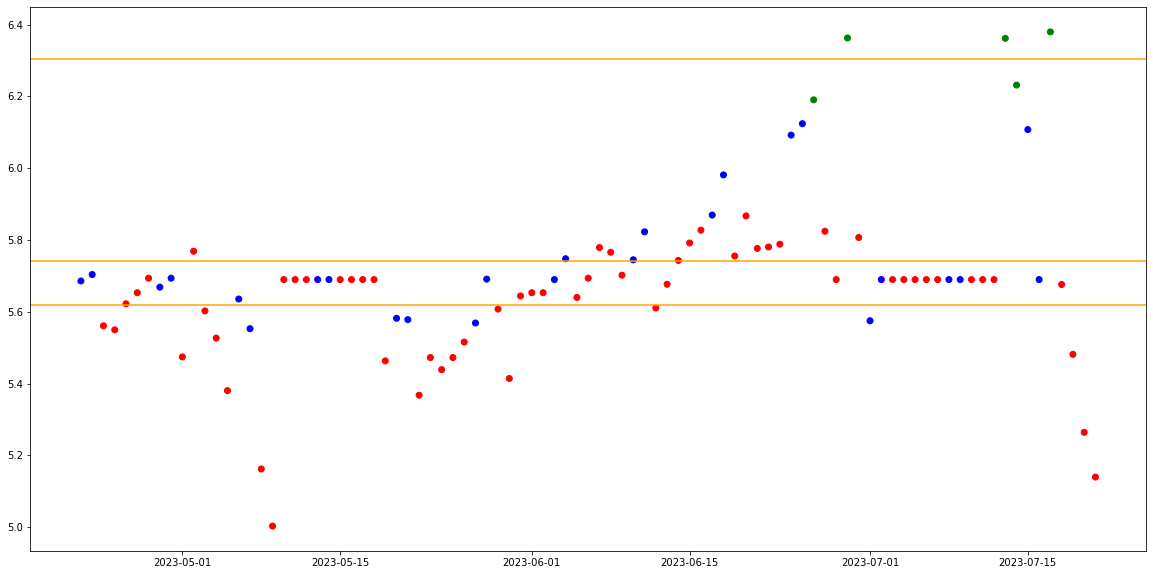

In [36]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots(figsize=(20,10))
colors = {0:'red', 1:'blue', 2:'green', 3:'black'}
ax.scatter(box_x_train['date_'], box_x_train['Sales'], c=box_x_train["cluster"].apply(lambda x: colors[x]))
ax.axhline(y = box_x_train[box_x_train['cluster'] == minimum]['Sales'].mean(), color='orange')
ax.axhline(y = box_x_train[box_x_train['cluster'] == no_outleir_key]['Sales'].mean(), color='orange')
ax.axhline(y = box_x_train[box_x_train['cluster'] == maximum]['Sales'].mean(), color='orange')
plt.show()

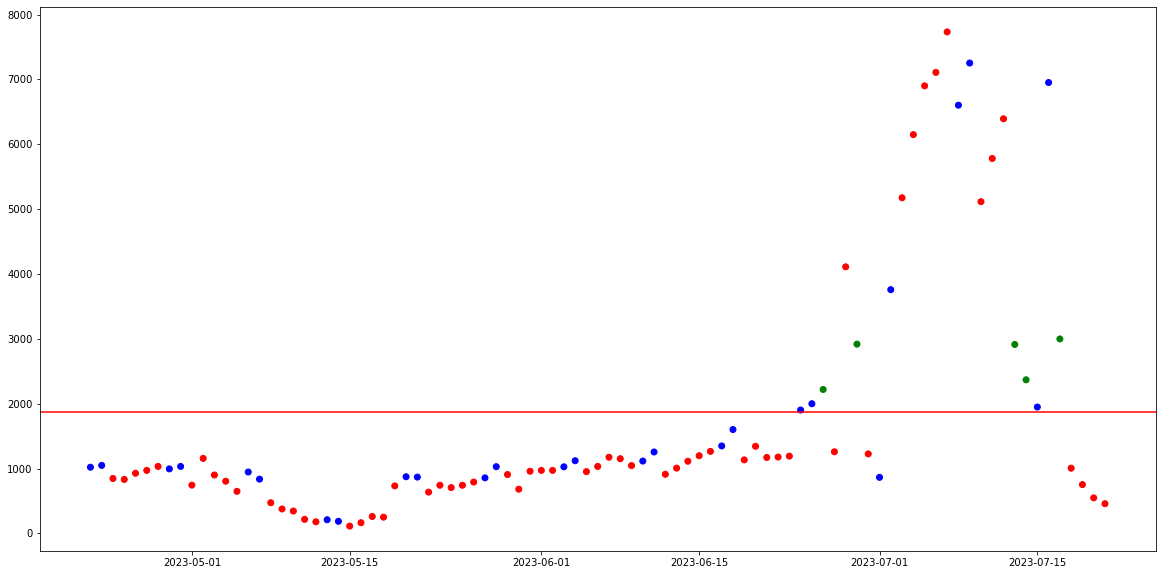

In [37]:
min_val = box_x_train[box_x_train['cluster'] == minimum]['sales_quantity'].mean()
max_val = box_x_train[box_x_train['cluster'] == maximum]['sales_quantity'].mean()
fval = box_x_train[box_x_train['cluster'] == no_outleir_key]['sales_quantity'].mean()
min_fval, max_fval = fval, fval

fig, ax = plt.subplots(figsize=(20,10))
colors = {0:'red', 1:'blue', 2:'green', 3:'black'}
ax.scatter(box_x_train['date_'], box_x_train['sales_quantity'], c=box_x_train["cluster"].apply(lambda x: colors[x]))
ax.axhline(y = fval, color='r')
plt.show()

In [38]:
min_val, max_val

(1610.6166666666666, 2683.2)

1610.6166666666666 2683.2


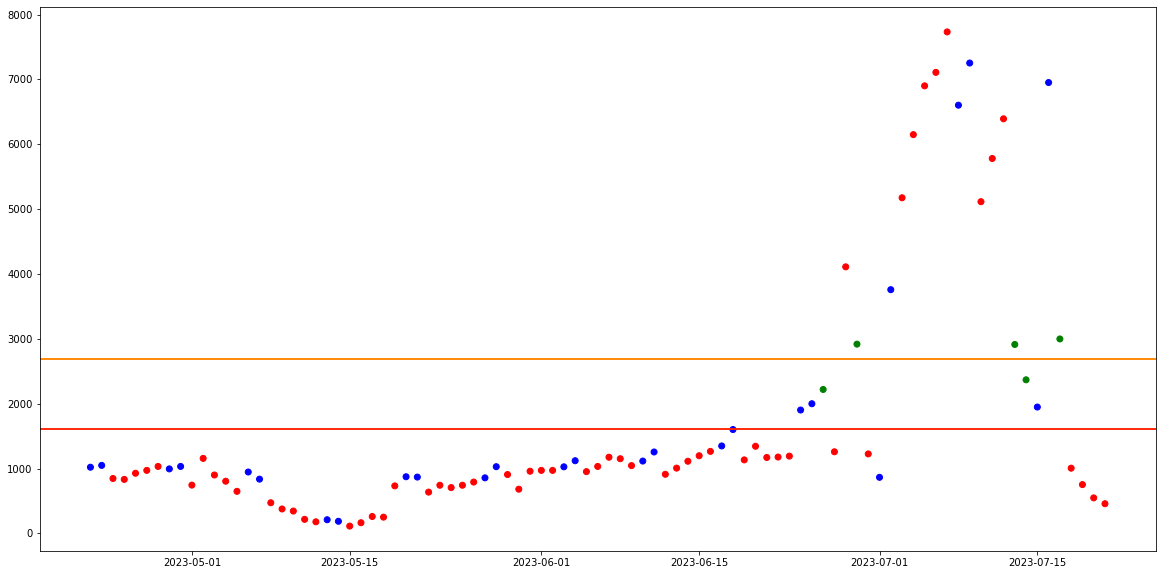

In [39]:
# min_fval = (min_val + min_fval)/2
# max_fval = (max_val + max_fval)/2
# print(min_fval, max_fval)
min_fval = min_val
max_fval = max_val
print(min_fval, max_fval)
fig, ax = plt.subplots(figsize=(20,10))
colors = {0:'red', 1:'blue', 2:'green', 3:'black'}
ax.scatter(box_x_train['date_'], box_x_train['sales_quantity'], c=box_x_train["cluster"].apply(lambda x: colors[x]))
ax.axhline(y = box_x_train[box_x_train['cluster'] == minimum]['sales_quantity'].mean(), color='orange')
ax.axhline(y = min_fval, color='r')
ax.axhline(y = max_fval, color='r')
ax.axhline(y = box_x_train[box_x_train['cluster'] == maximum]['sales_quantity'].mean(), color='orange')
plt.show()

In [40]:
box_x_train.head()

,date_,p_type,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,ipc,Sales,hours,week,day,month,DayOfTheWeek,WeekDay,cluster
0,2023-04-22,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1020,26386.0,27540.0,0.245811,5.685929,0,16,22,4,5,0,1
1,2023-04-23,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1048,27131.0,28294.0,0.238974,5.703906,0,16,23,4,6,0,1
2,2023-04-24,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,846,21932.0,22842.0,0.249967,5.560981,0,17,24,4,0,1,0
3,2023-04-25,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,832,21530.0,22464.0,0.231127,5.549767,0,17,25,4,1,1,0
4,2023-04-26,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,927,23978.0,25029.0,0.222459,5.622235,0,17,26,4,2,1,0


In [41]:
box_x_train['india_outlier_flag'] = np.where(box_x_train['cluster'].isin([minimum, maximum]), 1, 0)

In [42]:
box_x_train.head()

,date_,p_type,item_id,item_name,sales_quantity,sales_value,sales_value_mrp,ipc,Sales,hours,week,day,month,DayOfTheWeek,WeekDay,cluster,india_outlier_flag
0,2023-04-22,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1020,26386.0,27540.0,0.245811,5.685929,0,16,22,4,5,0,1,0
1,2023-04-23,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,1048,27131.0,28294.0,0.238974,5.703906,0,16,23,4,6,0,1,0
2,2023-04-24,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,846,21932.0,22842.0,0.249967,5.560981,0,17,24,4,0,1,0,1
3,2023-04-25,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,832,21530.0,22464.0,0.231127,5.549767,0,17,25,4,1,1,0,1
4,2023-04-26,Tomato Puree,10000953,Hommade Tomato Puree(Tetra Pak) 200 g - Rs 27,927,23978.0,25029.0,0.222459,5.622235,0,17,26,4,2,1,0,1


In [43]:
box_x_train.to_csv('india_outlier_flag.csv', index = False)

# ------END---------